In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()
from pprint import pprint
import json

In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [3]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [4]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [5]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [6]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), round(buy[0][0]).astype(int)

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [7]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(10, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [8]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [9]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 9, 'skip': 14, 'population_size': 6, 'sigma': 0.766252217458979, 'learning_rate': 0.4314045607191414, 'size_network': 270}
time taken to train: 0.030289649963378906 seconds
stop after 100 iteration with investment 8.474099
    1 | 00m00s |    8.47410 |          0.4314 |            6.2656 |    0.7663 |       269.7507 |   14.1204 |        8.8493 | 

Search parameters {'window_size': 27, 'skip': 11, 'population_size': 3, 'sigma': 0.5388753356289714, 'learning_rate': 0.23710066961340148, 'size_network': 624}
time taken to train: 0.23029208183288574 seconds
stop after 100 iteration with investment 27.336901
    2 | 00m00s |   27.33690 |          0.2371 |            2.9210 |    0.5389 |       624

time taken to train: 3.1338114738464355 seconds
stop after 100 iteration with investment 22.015400
   21 | 00m03s |   22.01540 |          0.4234 |           46.4866 |    0.0987 |       884.7529 |    7.3012 |       31.8070 | 

Search parameters {'window_size': 6, 'skip': 14, 'population_size': 3, 'sigma': 0.8904663393383306, 'learning_rate': 0.05981337496891031, 'size_network': 241}
time taken to train: 0.026235580444335938 seconds
stop after 100 iteration with investment 1.652100
   22 | 00m00s |    1.65210 |          0.0598 |            3.3715 |    0.8905 |       240.5387 |   14.0886 |        6.1773 | 

Search parameters {'window_size': 15, 'skip': 2, 'population_size': 4, 'sigma': 0.8880533183168496, 'learning_rate': 0.4749878219111585, 'size_network': 553}
time taken to train: 0.13436555862426758 seconds
stop after 100 iteration with investment 9.559702
   23 | 00m00s |    9.55970 |          0.4750 |            4.4792 |    0.8881 |       553.2976 |    1.6310 |       14.6498 | 

Sear


Search parameters {'window_size': 11, 'skip': 2, 'population_size': 29, 'sigma': 0.9451463554857171, 'learning_rate': 0.2939534692975442, 'size_network': 276}
time taken to train: 0.5831694602966309 seconds
stop after 100 iteration with investment 3.146205
   42 | 00m01s |    3.14620 |          0.2940 |           29.3599 |    0.9451 |       275.9367 |    2.1773 |       11.3351 | 

Search parameters {'window_size': 22, 'skip': 10, 'population_size': 42, 'sigma': 0.9516165899642345, 'learning_rate': 0.0656641581669171, 'size_network': 893}
time taken to train: 2.1046414375305176 seconds
stop after 100 iteration with investment 8.972399
   43 | 00m02s |    8.97240 |          0.0657 |           41.7993 |    0.9516 |       893.2210 |   10.0408 |       22.3155 | 

Search parameters {'window_size': 34, 'skip': 2, 'population_size': 30, 'sigma': 0.47539480531470696, 'learning_rate': 0.07285268998344116, 'size_network': 665}
time taken to train: 5.861525058746338 seconds
stop after 100 iterati

time taken to train: 0.5790808200836182 seconds
stop after 100 iteration with investment 10.747201
   63 | 00m01s |   10.74720 |          0.2836 |            6.7088 |    0.1380 |       872.1466 |    7.5623 |       19.9959 | 

Search parameters {'window_size': 47, 'skip': 8, 'population_size': 24, 'sigma': 0.8691188873844752, 'learning_rate': 0.3346752193131142, 'size_network': 842}
time taken to train: 1.8479793071746826 seconds
stop after 100 iteration with investment 0.671097
   64 | 00m02s |    0.67110 |          0.3347 |           23.8963 |    0.8691 |       841.9942 |    8.2552 |       47.1652 | 

Search parameters {'window_size': 36, 'skip': 11, 'population_size': 12, 'sigma': 0.6365393876377299, 'learning_rate': 0.12417569291036804, 'size_network': 269}
time taken to train: 0.3967101573944092 seconds
stop after 100 iteration with investment -1.202501
   65 | 00m01s |   -1.20250 |          0.1242 |           12.2288 |    0.6365 |       268.6791 |   11.2655 |       36.1081 | 

Sea

In [10]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 33.251105
Best AGENT parameters:  {'window_size': 44.29885747382228, 'skip': 5.02619725053567, 'population_size': 45.779097639393825, 'sigma': 0.4305809118954082, 'learning_rate': 0.2894954031004703, 'size_network': 228.83363943802325}


In [11]:
bayes_res = str(NN_BAYESIAN.res['max']['max_params'])
bayes_res = json.loads(bayes_res.replace("'", "\""))
bayes_res['window_size'] = int(round(bayes_res['window_size']))
bayes_res['skip'] = int(round(bayes_res['skip']))
bayes_res['population_size'] = int(round(bayes_res['population_size']))
bayes_res['size_network'] = int(round(bayes_res['size_network']))
pprint(bayes_res)

{'learning_rate': 0.2894954031004703,
 'population_size': 46,
 'sigma': 0.4305809118954082,
 'size_network': 229,
 'skip': 5,
 'window_size': 44}


In [12]:
# this is my parameter
best_agent(30, 1, 15, 0.1, 0.03, 500)

time taken to train: 4.442840337753296 seconds


30.464446949999946

In [13]:
# this is from bayesian
best_agent(bayes_res['window_size'], bayes_res['skip'], bayes_res['population_size'], bayes_res['sigma'], bayes_res['learning_rate'], bayes_res['size_network'])

time taken to train: 3.8266963958740234 seconds


28.257498200000008

iter 100. reward: 15.205045
iter 200. reward: 39.219050
iter 300. reward: 52.556249
iter 400. reward: 56.206047
iter 500. reward: 57.143555
time taken to train: 246.6761908531189 seconds
day 1: buy 1 units at price 762.130005, total balance 9237.869995
day 2: buy 5 units at price 3810.100100, total balance 5427.769895
day 3, sell 5 units at price 3912.600100, investment 413.376993 %, total balance 9340.369995,
day 4, sell 1 units at price 790.510010, investment -79.252251 %, total balance 10130.880005,
day 6: buy 5 units at price 3812.799990, total balance 6318.080015
day 7: buy 5 units at price 3770.100100, total balance 2547.979915
day 8: buy 1 units at price 736.080017, total balance 1811.899898
day 9: buy 5 units at price 3792.449950, total balance -1980.550052
day 10, sell 5 units at price 3822.399900, investment 0.251781 %, total balance 1841.849848,
day 11, sell 5 units at price 3856.149900, investment 2.282427 %, total balance 5697.999748,
day 13, sell 5 units at price 3846.000

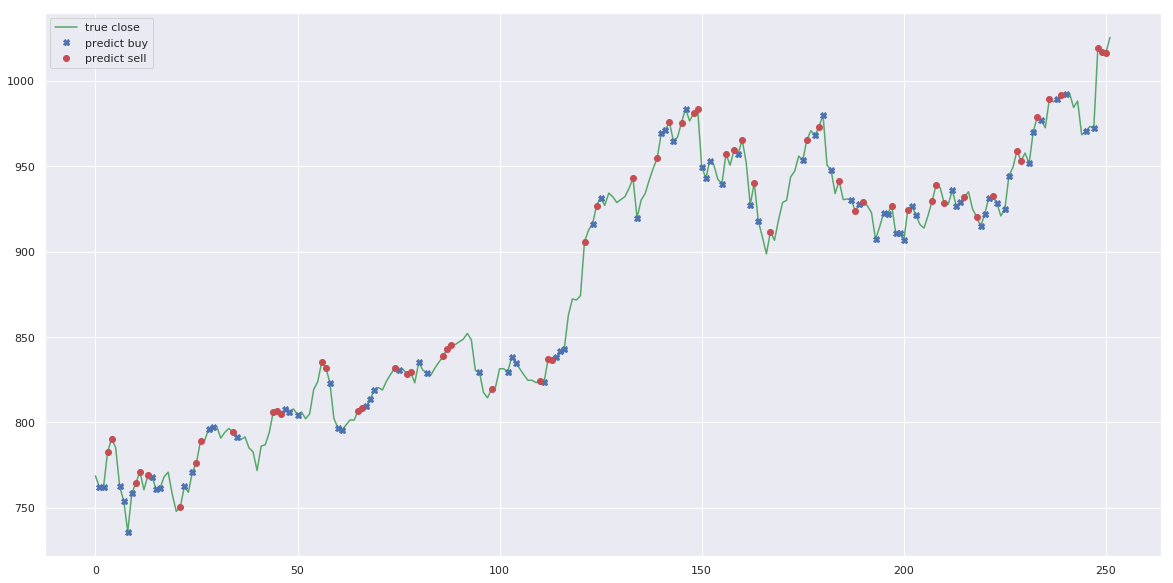

In [14]:
# this is my parameter
model = Model(30, 500, 3)
agent = Agent(15, 0.1, 0.03, model, 10000, 5, 5, 1, 30)
agent.fit(500, 100)
agent.buy()

iter 100. reward: 50.356402
iter 200. reward: 51.870405
time taken to train: 85.90280675888062 seconds
day 5: buy 5 units at price 3926.549990, total balance 6073.450010
day 10: buy 5 units at price 3822.399900, total balance 2251.050110
day 15: buy 1 units at price 760.989990, total balance 1490.060120
day 20: buy 5 units at price 3739.599915, total balance -2249.539795
day 25, sell 5 units at price 3882.099915, investment -1.132039 %, total balance 1632.560120,
day 30: buy 1 units at price 797.849976, total balance 834.710144
day 40: buy 5 units at price 3859.100035, total balance -3024.389891
day 45, sell 5 units at price 4033.250120, investment 5.516174 %, total balance 1008.860229,
day 50: buy 5 units at price 4023.049925, total balance -3014.189696
day 55, sell 5 units at price 4119.349975, investment 441.314607 %, total balance 1105.160279,
day 60: buy 5 units at price 3983.949890, total balance -2878.789611
day 65, sell 5 units at price 4034.849855, investment 7.895228 %, total

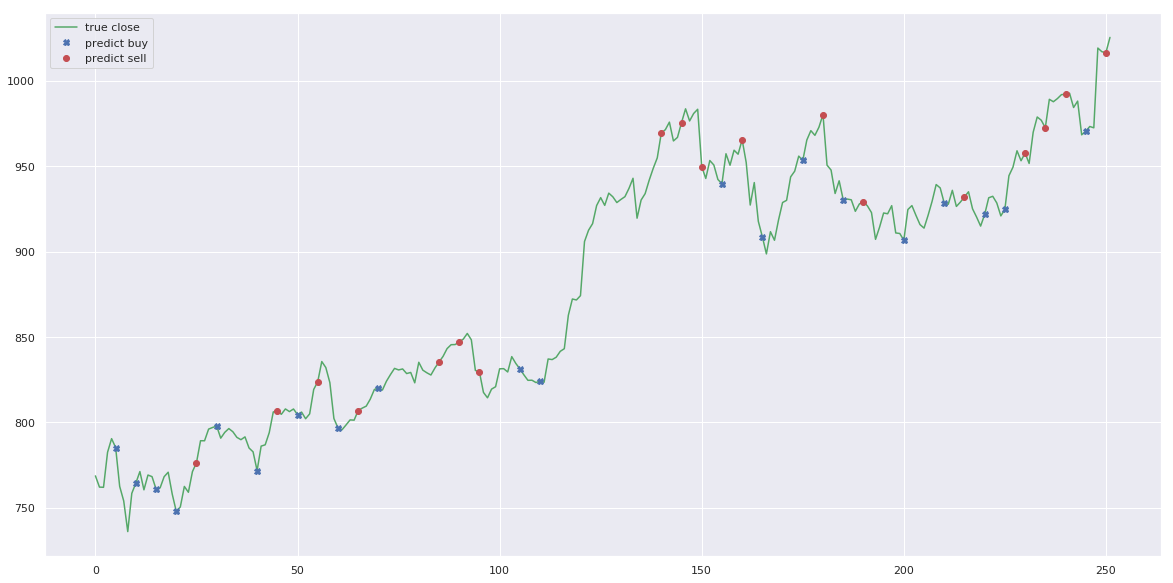

In [15]:
# this is from bayesian
model = Model(bayes_res['window_size'], bayes_res['size_network'], 3)
agent = Agent(
    bayes_res['population_size'], bayes_res['sigma'], bayes_res['learning_rate'], model, 10000, 5, 5, bayes_res['skip'], bayes_res['window_size']
)
agent.fit(bayes_res['size_network'], 100)
agent.buy()